In [2]:
import os
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')
pplt.rc.update({'figure.dpi':100})

In [3]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/data/interim'

In [4]:
pr     = xr.open_dataarray(f'{FILEDIR}/pr.nc',engine='h5netcdf')
lf     = xr.open_dataarray(f'{FILEDIR}/lf.nc',engine='h5netcdf')
lhf    = xr.open_dataarray(f'{FILEDIR}/lhf.nc',engine='h5netcdf')
shf    = xr.open_dataarray(f'{FILEDIR}/shf.nc',engine='h5netcdf')
bl     = xr.open_dataarray(f'{FILEDIR}/bl.nc',engine='h5netcdf')
cape   = xr.open_dataarray(f'{FILEDIR}/cape.nc',engine='h5netcdf')
subsat = xr.open_dataarray(f'{FILEDIR}/subsat.nc',engine='h5netcdf')
rh     = xr.open_dataarray(f'{FILEDIR}/rh.nc',engine='h5netcdf')
thetae = xr.open_dataarray(f'{FILEDIR}/thetae.nc',engine='h5netcdf')
thetaestar = xr.open_dataarray(f'{FILEDIR}/thetaestar.nc',engine='h5netcdf')

In [13]:
prflat = pr.stack(sample=('time','lat','lon'))
rhflat = rh.sel(lev=700).stack(sample=('time','lat','lon'))

valid  = np.isfinite(prflat)&np.isfinite(rhflat)
prflat = prflat.where(valid,drop=True).values
rhflat = rhflat.where(valid,drop=True).values

In [29]:
uselog = False
y = np.log1p(prflat) if uselog else prflat
ylabel = 'log1p(Precipitation)' if uselog else 'Precipitation (mm/hr)'

bins    = np.arange(0,101,10)
centers = 0.5*(bins[:-1]+bins[1:])

qlo  = np.full(centers.size,np.nan)  
qmed = np.full(centers.size,np.nan)   
qhi  = np.full(centers.size,np.nan)  
q05  = np.full(centers.size,np.nan)   
q95  = np.full(centers.size,np.nan)
counts = np.zeros(centers.size,dtype=int)

for i,(lo,hi) in enumerate(zip(bins[:-1],bins[1:])):
    m  = (rhflat>=lo)&(rhflat <hi)
    yi = y[m]
    yi = yi[np.isfinite(yi)]
    counts[i] = yi.size
    if yi.size>=20:
        q05[i],qlo[i],qmed[i],qhi[i],q95[i] = np.nanpercentile(yi,[5,25,50,75,95])

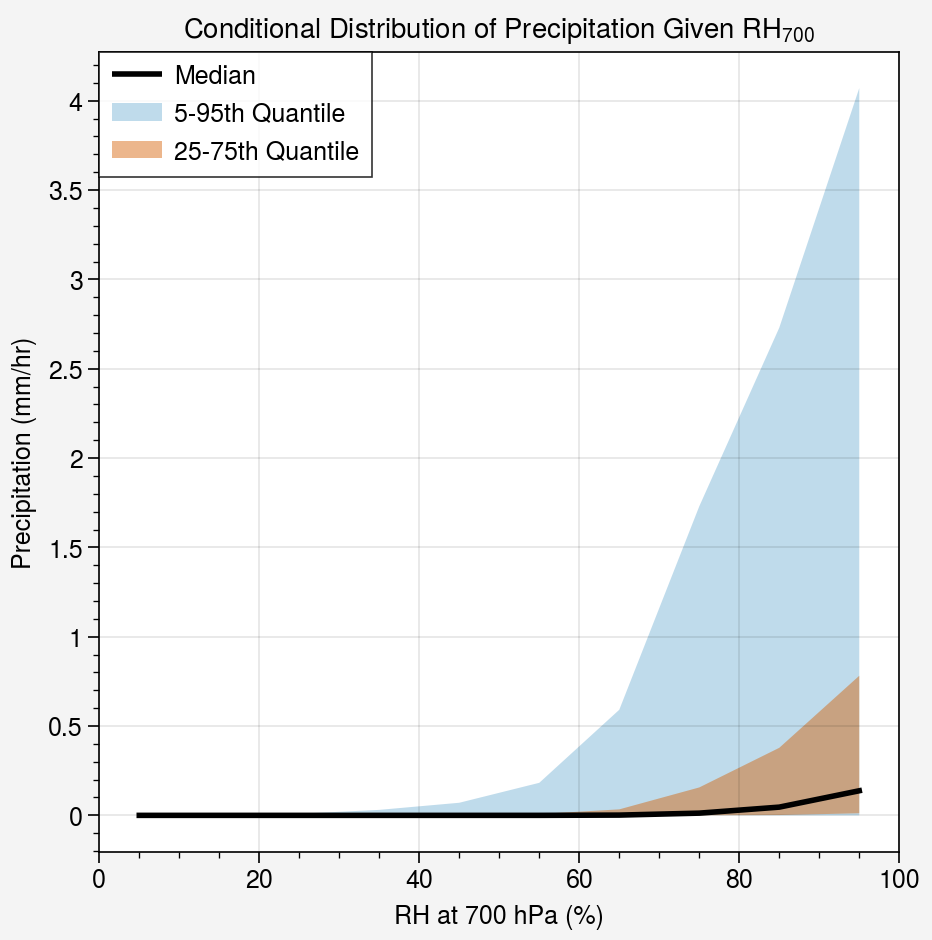

In [24]:
fig,ax = pplt.subplots(refwidth=4,refheight=4)
ax.fill_between(centers,q05,q95,alpha=0.25,label='5-95th Quantile')
ax.fill_between(centers,qlo,qhi,alpha=0.45,label='25-75th Quantile')
ax.plot(centers,qmed,color='k',linewidth=2,label='Median')
ax.format(title='Conditional Distribution of Precipitation Given $RH_{700}$',xlabel='RH at 700 hPa (%)',xlim=(0,100),ylabel=ylabel)
ax.legend(loc='ul',ncols=1)
pplt.show()

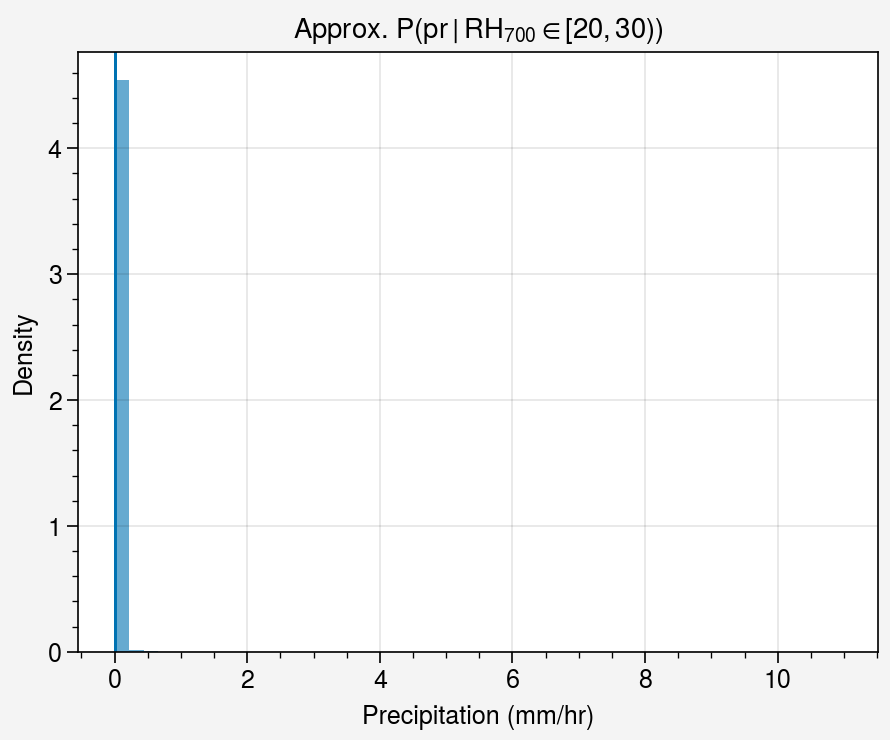

In [30]:
lo,hi = 20,30
m  = (rhflat>=lo)&(rhflat <hi)
yi = y[m]
yi = yi[np.isfinite(yi)]

fig,ax = pplt.subplots(refwidth=4,refheight=3)

# full shape (approx): histogram + KDE-ish smooth (optional)
ax.hist(yi, bins=50, density=True, alpha=0.6)

# mark quantiles (optional)
qs = np.nanpercentile(yi, [5,25,50,75,95])
for q in qs:
    ax.axvline(q, lw=1)

ax.format(
    title=fr'Approx. $P(pr \mid RH_{{700}}\in[{lo},{hi}))$',
    xlabel=ylabel,
    ylabel='Density'
)
pplt.show()

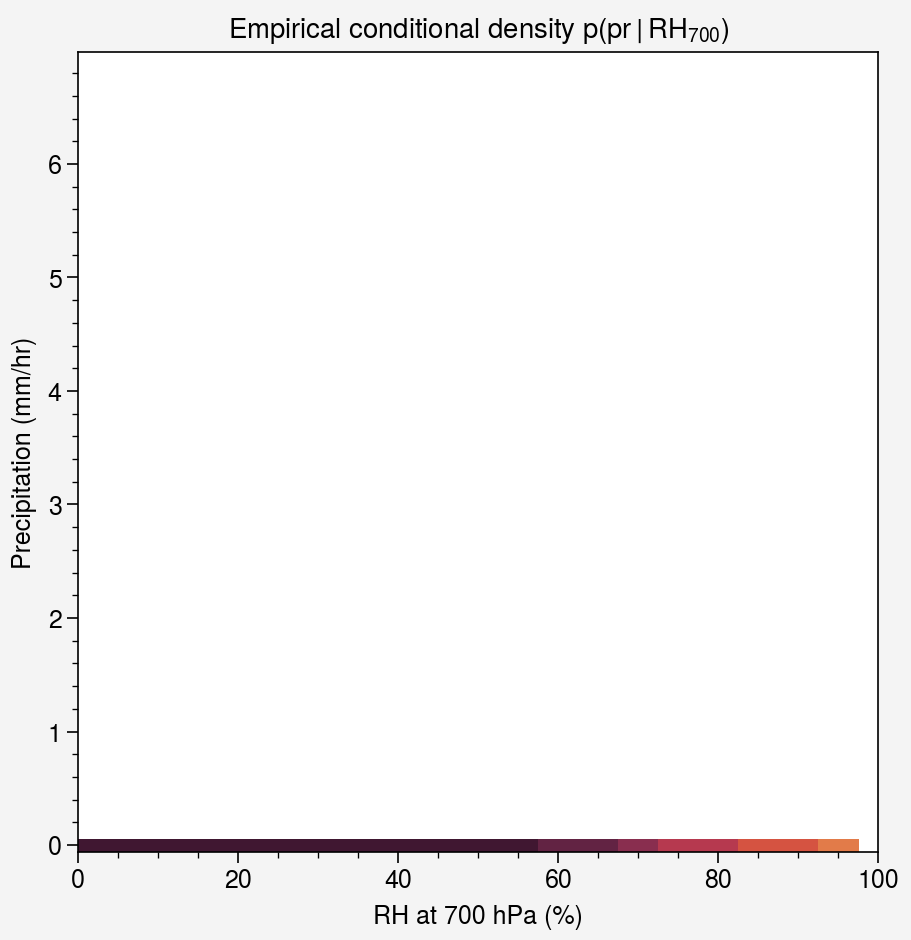

In [31]:
xbins = np.arange(0,101,5)
xcent = 0.5*(xbins[:-1]+xbins[1:])

ybins = np.linspace(np.nanmin(y), np.nanpercentile(y, 99.5), 60)
ycent = 0.5*(ybins[:-1]+ybins[1:])

H = np.full((ycent.size, xcent.size), np.nan)

for i,(lo,hi) in enumerate(zip(xbins[:-1], xbins[1:])):
    m  = (rhflat>=lo)&(rhflat <hi)
    yi = y[m]
    yi = yi[np.isfinite(yi)]
    if yi.size < 50:
        continue
    h,_ = np.histogram(yi, bins=ybins, density=False)
    H[:,i] = h / np.nansum(h)  # normalize -> conditional density per RH bin

fig,ax = pplt.subplots(refwidth=4, refheight=4)
ax.pcolormesh(xbins, ybins, np.pad(H, ((0,1),(0,1)), constant_values=np.nan), rasterized=True)
ax.format(
    title=r'Empirical conditional density $p(pr \mid RH_{700})$',
    xlabel='RH at 700 hPa (%)',
    ylabel=ylabel,
    xlim=(0,100)
)
pplt.show()